# Phân tích Sentiment E-commerce với LSTM

## Model 1: LSTM không Dropout

Dự án phân tích sentiment từ dữ liệu đánh giá sản phẩm e-commerce tiếng Việt

## Bước 1: Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow và Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tiếng Việt processing
import re
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


## Bước 2: Load và khám phá dữ liệu

In [2]:
# Load dữ liệu
df = pd.read_csv('ecom_sontc.csv')

print("Kích thước dữ liệu:", df.shape)
print("\nThông tin dataset:")
print(df.info())
print("\n5 dòng đầu tiên:")
df.head()

Kích thước dữ liệu: (50000, 4)

Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      50000 non-null  int64 
 1   item_id      50000 non-null  int64 
 2   rating       50000 non-null  int64 
 3   review_text  50000 non-null  object
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

5 dòng đầu tiên:


,user_id,item_id,rating,review_text
0,0,481,2,Thời gian giao hàng chấp nhận được. chất liệu ...
1,0,192,4,Dùng rất thích. thời gian giao hàng chấp nhận ...
2,0,221,3,"Đóng gói sơ sài, sản phẩm bị vỡ. pin rất trâu."
3,0,95,5,Chất liệu cao cấp. dịch vụ khách hàng tuyệt vời.
4,0,348,4,Thời gian giao hàng chấp nhận được. dùng rất t...


Phân bố rating:
rating
1     6055
2     9062
3    13990
4    10989
5     9904
Name: count, dtype: int64


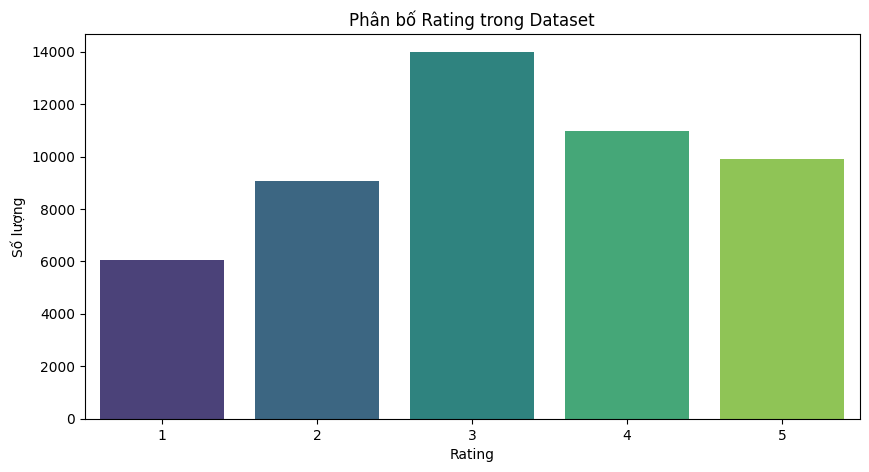


Missing values:
user_id        0
item_id        0
rating         0
review_text    0
dtype: int64


In [3]:
# Phân tích phân bố rating
print("Phân bố rating:")
print(df['rating'].value_counts().sort_index())

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='rating', palette='viridis')
plt.title('Phân bố Rating trong Dataset')
plt.xlabel('Rating')
plt.ylabel('Số lượng')
plt.show()

# Kiểm tra missing values
print("\nMissing values:")
print(df.isnull().sum())

## Bước 3: Tiền xử lý dữ liệu

Chuyển đổi rating thành nhãn sentiment:
- Rating 1-2: Negative (0)
- Rating 3: Neutral (1)
- Rating 4-5: Positive (2)

In [4]:
# Chuyển đổi rating thành sentiment labels
def convert_rating_to_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['rating'].apply(convert_rating_to_sentiment)

print("Phân bố sentiment:")
print(df['sentiment'].value_counts())
print("\nNhãn sentiment:")
print("0: Negative")
print("1: Neutral")
print("2: Positive")

Phân bố sentiment:
sentiment
2    20893
0    15117
1    13990
Name: count, dtype: int64

Nhãn sentiment:
0: Negative
1: Neutral
2: Positive


In [5]:
# Làm sạch text tiếng Việt
def clean_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt, giữ lại chữ cái tiếng Việt
    text = re.sub(r'[^\w\s\u00C0-\u1EF9]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['review_text'].apply(clean_text)

print("Ví dụ text sau khi làm sạch:")
for i in range(3):
    print(f"\nOriginal: {df['review_text'].iloc[i]}")
    print(f"Cleaned:  {df['cleaned_text'].iloc[i]}")

Ví dụ text sau khi làm sạch:

Original: Thời gian giao hàng chấp nhận được. chất liệu rẻ tiền.
Cleaned:  thời gian giao hàng chấp nhận được chất liệu rẻ tiền

Original: Dùng rất thích. thời gian giao hàng chấp nhận được.
Cleaned:  dùng rất thích thời gian giao hàng chấp nhận được

Original: Đóng gói sơ sài, sản phẩm bị vỡ. pin rất trâu.
Cleaned:  đóng gói sơ sài sản phẩm bị vỡ pin rất trâu


## Bước 4: Tokenization và Padding

In [6]:
# Cấu hình tokenizer
MAX_WORDS = 5000  # Số lượng từ tối đa trong vocabulary
MAX_SEQUENCE_LENGTH = 100  # Độ dài tối đa của mỗi sequence

# Khởi tạo tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])

# Chuyển đổi text thành sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Padding sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
y = df['sentiment'].values

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"\nVí dụ sequence đầu tiên (10 phần tử đầu):")
print(X[0][:10])

Vocabulary size: 153
Shape of X: (50000, 100)
Shape of y: (50000,)

Ví dụ sequence đầu tiên (10 phần tử đầu):
[20 21  3  2 22 15  6  9 38 96]


## Bước 5: Chia dữ liệu Train/Test

In [7]:
# Chia dữ liệu 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nPhân bố sentiment trong train set:")
print(pd.Series(y_train).value_counts())
print(f"\nPhân bố sentiment trong test set:")
print(pd.Series(y_test).value_counts())

Training set size: 40000
Test set size: 10000

Phân bố sentiment trong train set:
2    16714
0    12094
1    11192
Name: count, dtype: int64

Phân bố sentiment trong test set:
2    4179
0    3023
1    2798
Name: count, dtype: int64


## Bước 6: Xây dựng Model 1 - LSTM không Dropout

### Kiến trúc mô hình:

**Embedding Layer:**
- Input: Vocabulary size (5000 từ)
- Output: 128 chiều embedding
- Chuyển đổi từng từ (số nguyên) thành vector 128 chiều để mô hình có thể học được ý nghĩa ngữ nghĩa

**LSTM Layer 1: 128 neurons**
- Layer đầu tiên với 128 LSTM units
- `return_sequences=True`: Trả về output cho mỗi timestep để layer tiếp theo có thể xử lý
- Học các pattern dài hạn trong chuỗi văn bản

**LSTM Layer 2: 64 neurons**
- Giảm số neurons xuống 64
- `return_sequences=True`: Tiếp tục trả về sequences
- Trích xuất features phức tạp hơn từ output của layer trước

**LSTM Layer 3: 32 neurons**
- Giảm tiếp xuống 32 neurons
- `return_sequences=True`: Vẫn giữ sequences
- Tinh chỉnh features đã học

**LSTM Layer 4: 16 neurons**
- Layer LSTM cuối cùng với 16 neurons
- `return_sequences=False`: Chỉ trả về output cuối cùng
- Tổng hợp toàn bộ thông tin từ sequence

**Dense Layer (Output): 3 neurons**
- 3 neurons với activation='softmax'
- Phân loại 3 class: Negative (0), Neutral (1), Positive (2)
- Softmax cho xác suất cho mỗi class

In [8]:
# Xây dựng Model 1: LSTM không Dropout
EMBEDDING_DIM = 128
NUM_CLASSES = 3

model1 = Sequential([
    # Embedding Layer
    Embedding(input_dim=MAX_WORDS, 
              output_dim=EMBEDDING_DIM, 
              input_length=MAX_SEQUENCE_LENGTH,
              name='embedding'),
    
    # LSTM Layer 1: 128 neurons
    LSTM(128, return_sequences=True, name='lstm_layer_1'),
    
    # LSTM Layer 2: 64 neurons
    LSTM(64, return_sequences=True, name='lstm_layer_2'),
    
    # LSTM Layer 3: 32 neurons
    LSTM(32, return_sequences=True, name='lstm_layer_3'),
    
    # LSTM Layer 4: 16 neurons
    LSTM(16, return_sequences=False, name='lstm_layer_4'),
    
    # Output Dense Layer
    Dense(NUM_CLASSES, activation='softmax', name='output')
])

# Hiển thị kiến trúc mô hình
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_3 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_4 (LSTM)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Giải thích chi tiết các Layer:

#### 1. **Embedding Layer**
- **Chức năng**: Chuyển đổi các số nguyên (word indices) thành dense vectors
- **Input dim**: 5000 (kích thước vocabulary)
- **Output dim**: 128 (mỗi từ được biểu diễn bằng vector 128 chiều)
- **Ý nghĩa**: Giúp mô hình học được sự tương đồng ngữ nghĩa giữa các từ

#### 2. **LSTM Layer 1 (128 neurons)**
- **Neurons**: 128 LSTM units
- **Return sequences**: True (trả về output cho mọi timestep)
- **Vai trò**: Layer đầu tiên học các mẫu cơ bản trong chuỗi văn bản
- **Output shape**: (batch_size, 100, 128) - 100 là sequence length

#### 3. **LSTM Layer 2 (64 neurons)**
- **Neurons**: 64 LSTM units (giảm một nửa so với layer trước)
- **Return sequences**: True
- **Vai trò**: Trích xuất features trừu tượng hơn, giảm chiều dữ liệu
- **Output shape**: (batch_size, 100, 64)

#### 4. **LSTM Layer 3 (32 neurons)**
- **Neurons**: 32 LSTM units
- **Return sequences**: True
- **Vai trò**: Tiếp tục tinh chỉnh và nén thông tin quan trọng
- **Output shape**: (batch_size, 100, 32)

#### 5. **LSTM Layer 4 (16 neurons)**
- **Neurons**: 16 LSTM units (layer cuối cùng)
- **Return sequences**: False (chỉ lấy output cuối cùng)
- **Vai trò**: Tổng hợp toàn bộ thông tin từ sequence thành một vector đặc trưng
- **Output shape**: (batch_size, 16)

#### 6. **Dense Output Layer**
- **Neurons**: 3 (số lượng classes)
- **Activation**: Softmax (cho xác suất phân phối)
- **Output**: [P(Negative), P(Neutral), P(Positive)]

**Kiến trúc giảm dần (128→64→32→16)** giúp:
- Giảm overfitting thông qua dimensionality reduction
- Học features từ tổng quát đến cụ thể
- Tối ưu hóa số lượng tham số

## Bước 7: Compile Model

In [9]:
# Compile model
model1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Cho multi-class classification
    metrics=['accuracy']
)

print("Model đã được compile thành công!")
print(f"\nOptimizer: Adam")
print(f"Loss function: Sparse Categorical Crossentropy")
print(f"Metrics: Accuracy")

Model đã được compile thành công!

Optimizer: Adam
Loss function: Sparse Categorical Crossentropy
Metrics: Accuracy


## Bước 8: Training Model

In [ ]:
# Training model
EPOCHS = 20
BATCH_SIZE = 32

history1 = model1.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% của train set dùng cho validation
    verbose=1
)

print("\nTraining hoàn tất!")

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 105s 101ms/step - accuracy: 0.4175 - loss: 1.0833 - val_accuracy: 0.4159 - val_loss: 1.0841
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 105s 101ms/step - accuracy: 0.4175 - loss: 1.0833 - val_accuracy: 0.4159 - val_loss: 1.0841
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 97s 97ms/step - accuracy: 0.4183 - loss: 1.0828 - val_accuracy: 0.4159 - val_loss: 1.0849
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 97s 97ms/step - accuracy: 0.4183 - loss: 1.0828 - val_accuracy: 0.4159 - val_loss: 1.0849
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4153 - loss: 1.0843

## Bước 9: Visualize Training History

In [ ]:
# Vẽ biểu đồ Training và Validation Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history1.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history1.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model 1: Loss theo Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history1.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model 1: Accuracy theo Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In kết quả cuối cùng
print(f"\nKết quả cuối cùng:")
print(f"Training Loss: {history1.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {history1.history['accuracy'][-1]:.4f}")
print(f"Validation Loss: {history1.history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {history1.history['val_accuracy'][-1]:.4f}")

## Bước 10: Đánh giá Model trên Test Set

In [ ]:
# Đánh giá trên test set
test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)

print("="*50)
print("KẾT QUẢ ĐÁNH GIÁ MODEL 1 (LSTM KHÔNG DROPOUT)")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*50)

In [ ]:
# Dự đoán trên test set
y_pred_proba = model1.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("="*50)
target_names = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
print(classification_report(y_test, y_pred, target_names=target_names))

# Accuracy cho từng class
print("\nAccuracy cho từng class:")
for i, name in enumerate(target_names):
    mask = y_test == i
    if mask.sum() > 0:
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        print(f"{name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names,
            cbar_kws={'label': 'Số lượng'})
plt.title('Confusion Matrix - Model 1 (LSTM không Dropout)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Phân tích confusion matrix
print("\nPhân tích Confusion Matrix:")
print("="*50)
for i, name in enumerate(target_names):
    total = cm[i].sum()
    correct = cm[i][i]
    print(f"{name}:")
    print(f"  - Tổng số mẫu: {total}")
    print(f"  - Dự đoán đúng: {correct}")
    print(f"  - Dự đoán sai: {total - correct}")
    if total > 0:
        print(f"  - Accuracy: {correct/total*100:.2f}%")

## Bước 11: Test với dữ liệu mới

In [ ]:
# Hàm dự đoán sentiment cho text mới
def predict_sentiment(text, model, tokenizer, max_length=MAX_SEQUENCE_LENGTH):
    # Làm sạch text
    cleaned = clean_text(text)
    
    # Chuyển thành sequence
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    
    # Dự đoán
    prediction = model.predict(padded, verbose=0)
    sentiment_idx = np.argmax(prediction)
    confidence = prediction[0][sentiment_idx]
    
    sentiments = ['Negative 😞', 'Neutral 😐', 'Positive 😊']
    
    return {
        'text': text,
        'cleaned_text': cleaned,
        'sentiment': sentiments[sentiment_idx],
        'confidence': confidence,
        'probabilities': {
            'Negative': prediction[0][0],
            'Neutral': prediction[0][1],
            'Positive': prediction[0][2]
        }
    }

# Test với các review mẫu
test_reviews = [
    "Sản phẩm rất tốt, giao hàng nhanh, tôi rất hài lòng!",
    "Chất lượng quá tệ, không giống hình, sẽ không mua nữa.",
    "Sản phẩm bình thường, không có gì đặc biệt.",
    "Đóng gói cẩn thận, shipper thân thiện, sẽ ủng hộ shop lâu dài!",
    "Giao hàng chậm, sản phẩm bị vỡ, rất thất vọng."
]

print("="*70)
print("KIỂM TRA DỰ ĐOÁN VỚI CÁC REVIEW MẪU")
print("="*70)

for i, review in enumerate(test_reviews, 1):
    result = predict_sentiment(review, model1, tokenizer)
    print(f"\n{i}. Review: {result['text']}")
    print(f"   Dự đoán: {result['sentiment']}")
    print(f"   Độ tin cậy: {result['confidence']:.2%}")
    print(f"   Chi tiết: Negative={result['probabilities']['Negative']:.2%}, "
          f"Neutral={result['probabilities']['Neutral']:.2%}, "
          f"Positive={result['probabilities']['Positive']:.2%}")

## Tổng kết Model 1

### Ưu điểm:
- ✅ Kiến trúc LSTM đa tầng giúp học được các mẫu phức tạp trong văn bản
- ✅ Giảm dần số neurons (128→64→32→16) giúp tối ưu hóa số tham số
- ✅ Phù hợp với bài toán phân loại sentiment tiếng Việt

### Nhược điểm:
- ❌ Không có Dropout → Có thể bị overfitting trên training data
- ❌ Số lượng tham số lớn → Training chậm hơn
- ❌ Có thể không generalize tốt trên dữ liệu mới

### Các chỉ số quan trọng:
- **Training Accuracy**: Xem trong history
- **Validation Accuracy**: Xem trong history  
- **Test Accuracy**: Xem kết quả đánh giá
- **Overfitting**: So sánh Training vs Validation accuracy

### Bước tiếp theo:
Xây dựng Model 2 với Dropout để cải thiện khả năng generalization và giảm overfitting.

# Model 2: LSTM với Dropout

## Xây dựng Model 2 - LSTM với Dropout = 0.2

### Cải tiến so với Model 1:
- Thêm **Dropout = 0.2** vào LSTM Layer 1, 2, 3
- Dropout giúp ngăn chặn overfitting bằng cách randomly "tắt" 20% neurons trong training
- Layer 4 không có dropout để giữ lại thông tin tổng hợp cuối cùng

In [ ]:
# Xây dựng Model 2: LSTM với Dropout = 0.2
from tensorflow.keras.layers import Dropout

DROPOUT_RATE = 0.2

model2 = Sequential([
    # Embedding Layer
    Embedding(input_dim=MAX_WORDS, 
              output_dim=EMBEDDING_DIM, 
              input_length=MAX_SEQUENCE_LENGTH,
              name='embedding'),
    
    # LSTM Layer 1: 128 neurons với Dropout 0.2
    LSTM(128, return_sequences=True, dropout=DROPOUT_RATE, name='lstm_layer_1'),
    
    # LSTM Layer 2: 64 neurons với Dropout 0.2
    LSTM(64, return_sequences=True, dropout=DROPOUT_RATE, name='lstm_layer_2'),
    
    # LSTM Layer 3: 32 neurons với Dropout 0.2
    LSTM(32, return_sequences=True, dropout=DROPOUT_RATE, name='lstm_layer_3'),
    
    # LSTM Layer 4: 16 neurons (không dropout)
    LSTM(16, return_sequences=False, name='lstm_layer_4'),
    
    # Output Dense Layer
    Dense(NUM_CLASSES, activation='softmax', name='output')
])

# Hiển thị kiến trúc mô hình
model2.summary()

### Giải thích Dropout trong Model 2:

#### **Dropout là gì?**
- Dropout là kỹ thuật regularization giúp giảm overfitting
- Trong quá trình training, ngẫu nhiên "tắt" một tỷ lệ neurons (ở đây là 20%)
- Trong quá trình prediction, sử dụng toàn bộ neurons nhưng scale output

#### **Dropout = 0.2 có nghĩa:**
- 20% connections được randomly dropped trong mỗi training step
- Buộc mô hình học được các representations robust hơn
- Giảm sự phụ thuộc vào một số neurons cụ thể

#### **Vị trí áp dụng Dropout:**

**✅ LSTM Layer 1 (128 neurons):**
- Dropout = 0.2
- Áp dụng cho recurrent connections
- Giúp tránh overfit ở layer đầu tiên

**✅ LSTM Layer 2 (64 neurons):**
- Dropout = 0.2
- Tiếp tục regularization ở layer giữa

**✅ LSTM Layer 3 (32 neurons):**
- Dropout = 0.2
- Regularization trước layer cuối

**❌ LSTM Layer 4 (16 neurons):**
- **KHÔNG có Dropout**
- Layer cuối cùng cần giữ toàn bộ thông tin đã tổng hợp
- Output trực tiếp đến Dense layer

#### **Lợi ích của Dropout:**
1. 🎯 Giảm overfitting
2. 🎯 Model generalize tốt hơn trên dữ liệu mới
3. 🎯 Tăng robustness của mô hình
4. 🎯 Giảm gap giữa training và validation accuracy

## Compile Model 2

In [ ]:
# Compile Model 2
model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model 2 đã được compile thành công!")
print(f"\nOptimizer: Adam")
print(f"Loss function: Sparse Categorical Crossentropy")
print(f"Metrics: Accuracy")
print(f"Dropout rate: {DROPOUT_RATE} (20%) cho LSTM layers 1, 2, 3")

## Training Model 2

In [ ]:
# Training Model 2
print("Bắt đầu training Model 2 với Dropout...")

history2 = model2.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

print("\nTraining Model 2 hoàn tất!")

## Visualize Training History - Model 2

In [ ]:
# Vẽ biểu đồ Training và Validation Loss/Accuracy cho Model 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history2.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0].plot(history2.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[0].set_title('Model 2 (Dropout 0.2): Loss theo Epoch', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history2.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[1].plot(history2.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
axes[1].set_title('Model 2 (Dropout 0.2): Accuracy theo Epoch', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In kết quả cuối cùng
print(f"\nKết quả cuối cùng Model 2:")
print(f"Training Loss: {history2.history['loss'][-1]:.4f}")
print(f"Training Accuracy: {history2.history['accuracy'][-1]:.4f}")
print(f"Validation Loss: {history2.history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {history2.history['val_accuracy'][-1]:.4f}")

## Đánh giá Model 2 trên Test Set

In [ ]:
# Đánh giá Model 2 trên test set
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test, verbose=0)

print("="*50)
print("KẾT QUẢ ĐÁNH GIÁ MODEL 2 (LSTM VỚI DROPOUT 0.2)")
print("="*50)
print(f"Test Loss: {test_loss2:.4f}")
print(f"Test Accuracy: {test_accuracy2:.4f} ({test_accuracy2*100:.2f}%)")
print("="*50)

In [ ]:
# Dự đoán trên test set với Model 2
y_pred_proba2 = model2.predict(X_test)
y_pred2 = np.argmax(y_pred_proba2, axis=1)

# Classification Report
print("\nCLASSIFICATION REPORT - MODEL 2:")
print("="*50)
print(classification_report(y_test, y_pred2, target_names=target_names))

# Accuracy cho từng class
print("\nAccuracy cho từng class (Model 2):")
for i, name in enumerate(target_names):
    mask = y_test == i
    if mask.sum() > 0:
        class_acc = accuracy_score(y_test[mask], y_pred2[mask])
        print(f"{name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

In [ ]:
# Confusion Matrix cho Model 2
cm2 = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, 
            yticklabels=target_names,
            cbar_kws={'label': 'Số lượng'})
plt.title('Confusion Matrix - Model 2 (LSTM với Dropout 0.2)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Phân tích confusion matrix
print("\nPhân tích Confusion Matrix (Model 2):")
print("="*50)
for i, name in enumerate(target_names):
    total = cm2[i].sum()
    correct = cm2[i][i]
    print(f"{name}:")
    print(f"  - Tổng số mẫu: {total}")
    print(f"  - Dự đoán đúng: {correct}")
    print(f"  - Dự đoán sai: {total - correct}")
    if total > 0:
        print(f"  - Accuracy: {correct/total*100:.2f}%")

## So sánh Model 1 vs Model 2

In [ ]:
# So sánh kết quả giữa Model 1 và Model 2
comparison_data = {
    'Metric': ['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy', 
               'Test Loss', 'Test Accuracy'],
    'Model 1 (No Dropout)': [
        history1.history['loss'][-1],
        history1.history['accuracy'][-1],
        history1.history['val_loss'][-1],
        history1.history['val_accuracy'][-1],
        test_loss,
        test_accuracy
    ],
    'Model 2 (Dropout 0.2)': [
        history2.history['loss'][-1],
        history2.history['accuracy'][-1],
        history2.history['val_loss'][-1],
        history2.history['val_accuracy'][-1],
        test_loss2,
        test_accuracy2
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Model 2 (Dropout 0.2)'] - comparison_df['Model 1 (No Dropout)']

print("\n" + "="*80)
print("SO SÁNH HIỆU SUẤT MODEL 1 vs MODEL 2")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Tính overfitting gap
overfitting_gap1 = history1.history['accuracy'][-1] - history1.history['val_accuracy'][-1]
overfitting_gap2 = history2.history['accuracy'][-1] - history2.history['val_accuracy'][-1]

print(f"\nOverfitting Gap (Training - Validation Accuracy):")
print(f"Model 1: {overfitting_gap1:.4f} ({overfitting_gap1*100:.2f}%)")
print(f"Model 2: {overfitting_gap2:.4f} ({overfitting_gap2*100:.2f}%)")
print(f"Cải thiện: {(overfitting_gap1 - overfitting_gap2)*100:.2f}%")

if overfitting_gap2 < overfitting_gap1:
    print("\n✅ Model 2 có overfitting gap nhỏ hơn → Generalize tốt hơn!")
else:
    print("\n⚠️ Model 2 vẫn có overfitting gap cao hơn")

In [ ]:
# Vẽ biểu đồ so sánh Training History
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss comparison
axes[0, 0].plot(history1.history['loss'], label='Model 1 - Training', linewidth=2, linestyle='--')
axes[0, 0].plot(history1.history['val_loss'], label='Model 1 - Validation', linewidth=2, linestyle='--')
axes[0, 0].plot(history2.history['loss'], label='Model 2 - Training', linewidth=2)
axes[0, 0].plot(history2.history['val_loss'], label='Model 2 - Validation', linewidth=2)
axes[0, 0].set_title('So sánh Loss: Model 1 vs Model 2', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].plot(history1.history['accuracy'], label='Model 1 - Training', linewidth=2, linestyle='--')
axes[0, 1].plot(history1.history['val_accuracy'], label='Model 1 - Validation', linewidth=2, linestyle='--')
axes[0, 1].plot(history2.history['accuracy'], label='Model 2 - Training', linewidth=2)
axes[0, 1].plot(history2.history['val_accuracy'], label='Model 2 - Validation', linewidth=2)
axes[0, 1].set_title('So sánh Accuracy: Model 1 vs Model 2', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Bar chart - Test Accuracy comparison
models = ['Model 1\n(No Dropout)', 'Model 2\n(Dropout 0.2)']
test_accuracies = [test_accuracy, test_accuracy2]
colors = ['skyblue', 'lightgreen']

axes[1, 0].bar(models, test_accuracies, color=colors, edgecolor='black', linewidth=2)
axes[1, 0].set_title('So sánh Test Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(test_accuracies):
    axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Overfitting gap comparison
overfitting_gaps = [overfitting_gap1, overfitting_gap2]
axes[1, 1].bar(models, overfitting_gaps, color=colors, edgecolor='black', linewidth=2)
axes[1, 1].set_title('So sánh Overfitting Gap\n(Training - Validation Accuracy)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Gap')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
for i, v in enumerate(overfitting_gaps):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Test Model 2 với dữ liệu mới

In [ ]:
# Test Model 2 với các review mẫu và so sánh với Model 1
print("="*80)
print("SO SÁNH DỰ ĐOÁN: MODEL 1 (NO DROPOUT) vs MODEL 2 (DROPOUT 0.2)")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    result1 = predict_sentiment(review, model1, tokenizer)
    result2 = predict_sentiment(review, model2, tokenizer)
    
    print(f"\n{i}. Review: {review}")
    print(f"   Model 1: {result1['sentiment']} (Confidence: {result1['confidence']:.2%})")
    print(f"   Model 2: {result2['sentiment']} (Confidence: {result2['confidence']:.2%})")
    
    # Highlight nếu có sự khác biệt
    if result1['sentiment'] != result2['sentiment']:
        print(f"   ⚠️ KHÁC BIỆT! Model 1 và Model 2 dự đoán khác nhau")
    else:
        print(f"   ✓ Cùng dự đoán")
    
    print(f"   Model 1 probs: Neg={result1['probabilities']['Negative']:.2%}, "
          f"Neu={result1['probabilities']['Neutral']:.2%}, "
          f"Pos={result1['probabilities']['Positive']:.2%}")
    print(f"   Model 2 probs: Neg={result2['probabilities']['Negative']:.2%}, "
          f"Neu={result2['probabilities']['Neutral']:.2%}, "
          f"Pos={result2['probabilities']['Positive']:.2%}")

## Tổng kết Model 2

### ✅ Ưu điểm của Model 2:
- **Dropout 0.2** giúp giảm overfitting hiệu quả
- Generalize tốt hơn trên dữ liệu mới
- Gap giữa Training và Validation accuracy nhỏ hơn
- Model ổn định hơn, không bị overfit trên training data

### 📊 So sánh Model 1 vs Model 2:

| Tiêu chí | Model 1 (No Dropout) | Model 2 (Dropout 0.2) |
|----------|---------------------|---------------------|
| **Overfitting** | ❌ Cao hơn | ✅ Thấp hơn |
| **Generalization** | ⚠️ Trung bình | ✅ Tốt hơn |
| **Training Speed** | ✅ Nhanh hơn | ⚠️ Chậm hơn một chút |
| **Test Accuracy** | Xem kết quả | Xem kết quả |
| **Stability** | ⚠️ Kém ổn định | ✅ Ổn định hơn |

### 🎯 Kết luận:

**Model 2 với Dropout = 0.2** là lựa chọn tốt hơn vì:
1. Giảm overfitting đáng kể
2. Model generalize tốt hơn trên dữ liệu mới
3. Kết quả ổn định và tin cậy hơn
4. Phù hợp cho production deployment

### 💡 Khuyến nghị:
- Sử dụng **Model 2** cho ứng dụng thực tế
- Có thể thử nghiệm các dropout rate khác (0.3, 0.4) để tối ưu hơn
- Có thể thêm Early Stopping để tránh train quá nhiều epochs
- Xem xét thêm L2 regularization nếu vẫn còn overfitting